# Preprocessing Pipelines Prototyping for fasta straints
#### Researcher: VMLCODE

## Import pakages

In [130]:
import pandas as pd
import numpy as np
import os

from Bio import SeqIO
from Bio.SeqUtils import gc_fraction, molecular_weight
from itertools import product

In [131]:
def extract_sequences_from_directory(directory):
    sequences = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        for record in SeqIO.parse(filepath, "fasta"):
            seq = str(record.seq)
            if len(seq) > 0:
                sequences.append([seq, record.id])
    return sequences

In [132]:
def populate_amr_fasta_dataset(dir_path):
    df = pd.DataFrame(columns=['sample_id', 'sequence', 'label (not resistant[0]/resistant[1] to Trimethoprim)'])
    for directory in os.listdir(dir_path):
        if directory == '0':
            for seq in extract_sequences_from_directory(os.path.join(dir_path, directory)):
                df.loc[len(df)] = [seq[1], seq[0], 0]
        if directory == '1':
            for seq in extract_sequences_from_directory(os.path.join(dir_path, directory)):
                df.loc[len(df)] = [seq[1], seq[0], 1]
    df.to_csv('../Examples/amr_fasta_dataset.csv', index=False)    
populate_amr_fasta_dataset("../Examples")    

In [133]:
def get_amr_fasta_dataset():
    df = pd.read_csv('../Examples/amr_fasta_dataset.csv')
    df['sequence'] = df['sequence']
    df['sample_id'] = df['sample_id']
    df['label (not resistant[0]/resistant[1] to Trimethoprim)'] = df['label (not resistant[0]/resistant[1] to Trimethoprim)'].astype(int)
    return df

get_amr_fasta_dataset()

,sample_id,sequence,label (not resistant[0]/resistant[1] to Trimethoprim)
0,CP133856.1,TAACTCCCTATAATGCGCCACCACTGACACGGAACAACGGCAAACA...,0
1,CP173596.1,TTTCGCCCGGATGGATGTCCTGTACGGATAACTGGAACATAGTTCT...,0
2,CP173597.1,TTTTACTGCGCCGGCTGACGCGGCGCGGCAGGAACGCTGCCTGTGG...,0
3,CP173595.1,ACCTCCCGGAGTTTGTTCGGGACCATCCACCGCTCCATCTCACGGA...,0
4,CP173593.1,TCCGGATGATCGGATTCGACAGTGAAAGTTTTATCTGTCGCATTTG...,0
5,CP173594.1,ACTTCTTTGACGGCTTTTGGCGTTGCAGCGCGCGTTTCAGAAGTAC...,0
6,CP119740.1,GTGTCACTTTCGCTTTGGCAGCAGTGTCTTGCCCGATTGCAGGATG...,1
7,CP119741.1,TGGTTTATGGGGCCCTCTCCCTGATTCGCATGTCGTGCTTTTTCTT...,1
8,CP119742.1,GGGGCTGGAATGTCAACGTATCCCGGGTGATGGATAACGCCACACA...,1
9,CP119743.1,TACACCAATTAGGTAAAGTTATTTTTAAGTATCGAGGCAACTTTCA...,1


In [134]:
def get_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

In [135]:
def get_all_kmers_dict():
    bases = ['A', 'C', 'G', 'T']
    kmer_dict = {}
    kmers = [''.join(p) for p in product(bases, repeat=4)]
    for kmer in kmers:
            kmer_dict[kmer] = 0
    return kmer_dict 

In [136]:
def get_kmer_frequencies(sequence, k):
  kmer_list = get_kmers(sequence, k)
  kmer_dict = get_all_kmers_dict()
  for kmer in kmer_list:
        if kmer in kmer_dict:
         kmer_dict[kmer] += 1
  return kmer_dict

### Dataset 1 (Name: K-mer Frequency)

##### Example:
- **AAAA**: 3474 (Frequency of every KMer)  
- **AAAC**: 5938  
- **....**: ....  

##### Additional Information:
- **GC_content**: Percentage of nitrogenous bases in the strain  
- **Length**: Length of the chain  
- **AT_ratio**: Proportion of adenine and thymine  
- **Label**: Metadata for forensic analysis of the model  

In [137]:
def get_gc_content(sequence):
    return gc_fraction(sequence)

In [138]:
def get_sequence_length(sequence):
    return len(sequence)

In [139]:
def get_at_ratio(sequence):
    a_count = sequence.count('A')
    t_count = sequence.count('T')
    return (a_count + t_count) / len(sequence) if len(sequence) > 0 else 0

In [140]:
def get_molecular_weight(sequence):
  return molecular_weight(sequence, seq_type='DNA', monoisotopic=True)

In [141]:
def create_amr_fasta_kmer_dataset():
    df = get_amr_fasta_dataset()
    new_rows = []

    for i in range(len(df)):
        sequence = df['sequence'][i]
        kmer_frequencies = get_kmer_frequencies(sequence, 4)
        gc_content = get_gc_content(sequence)

        # Start with the original row (excluding 'sequence')
        row_data = df.drop(columns=['sequence']).iloc[i].to_dict()

        # Add k-mer frequencies to it
        row_data.update(kmer_frequencies)
        row_data['gc_content'] = gc_content
        row_data['sequence_length'] = get_sequence_length(sequence)
        row_data['at_ratio'] = get_at_ratio(sequence)
        row_data['molecular_weight'] = get_molecular_weight(sequence)

        new_rows.append(row_data)

    result_df = pd.DataFrame(new_rows)
    return result_df

df1=create_amr_fasta_kmer_dataset()
df1.to_csv('../Examples/amr_fasta_dataset_with_kmers.csv', index=False)

### Dataset 2 (Name: FCGR IMAGE 2D Matrix)
##### Example:
![FCGR_EXAMPLE](https://raw.githubusercontent.com/vmlcode/AMR-VSA25/refs/heads/main/docs/images/EXAMPLE_FCGR.png)

In [142]:
def base_to_vertex(base):
    mapping = {
        'A': np.array([1,0]),
        'G': np.array([0,1]),
        'C': np.array([1,1]),
        'T': np.array([0,0]),
    }
    return np.array(mapping.get(base, np.array([0,0])))

base_to_vertex('A')

array([1, 0])

In [143]:
def chaos_game_point(kmer):
    point= np.array([0.5, 0.5])
    for base in kmer:
        vertex = base_to_vertex(base)
        if vertex is None:
            return None
        point = point + vertex
        point = point / 2
    return point

In [144]:
def kmer_to_index(point, resolution):
    x = int(point[0] * resolution)
    y = int(point[1] * resolution)
    return x, y

In [145]:
def generate_fcgr(sequence, k, resolution):
    fcgr = np.zeros((resolution, resolution))
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        point = chaos_game_point(kmer)
        if point is not None:
            x, y = kmer_to_index(point, resolution)
            fcgr[x,y] += 1
    return fcgr

generate_fcgr(get_amr_fasta_dataset()["sequence"][1], 6, 64)


array([[3681., 3092., 2312., ...,  699.,  601.,  295.],
       [3528., 2862., 1841., ..., 1171.,  449.,  439.],
       [2492., 2769., 1902., ...,  411.,  486.,  943.],
       ...,
       [2598.,  919., 2483., ...,  522.,  812., 1107.],
       [2776., 3765., 1881., ...,  274.,  569.,  655.],
       [3653., 2801., 1962., ...,  572.,  346.,  273.]], shape=(64, 64))

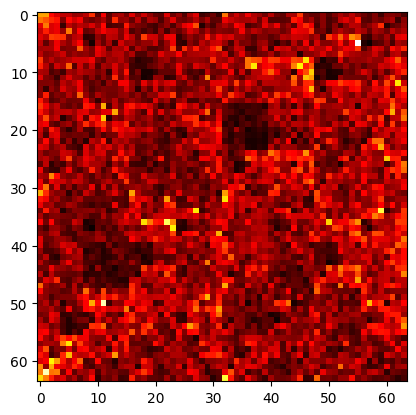

In [ ]:
plot_fcgr = generate_fcgr(get_amr_fasta_dataset()["sequence"][2], 6, 64)
import matplotlib.pyplot as plt
plt.imshow(plot_fcgr, cmap='hot', interpolation='nearest', )
plt.show()

In [161]:
def create_amr_fasta_fcgr_dataset():
    df = get_amr_fasta_dataset()
    new_rows = []

    seq = []
    for i in range(len(df)):
        sequence = df['sequence'][i]
        fcgr = generate_fcgr(sequence, 6, 64)
        row_data = df.drop(columns=['sequence']).iloc[i].to_dict()
        row_data['fcgr'] = fcgr.flatten().tolist()
        new_rows.append(row_data)
    result_df = pd.DataFrame(new_rows)
    return result_df
df2=create_amr_fasta_fcgr_dataset()
df2.to_csv('../Examples/amr_fasta_dataset_with_fcgr.csv', index=False)
        
